# Multiclass Classification

In this problem we will design a neural network to classify newsreels from Reuters dataset into 46 mutually exclusive classes using the Python library, Keras. Thus, this problem is more specifically a _single-label, multiclass classification_ problem.

## About the Reuters dataset

The _Reuters dataset_ is a set of short newswires sorted into 46 _mutually exclusive_ topics. It was published by _Reuters_ in 1986. This dataset is widely used for text classification. There are 46 topics, where some topics are represented more than others. However, each topic contains atleast 10 examples in the training set.

The _reuters dataset_ comes pleloaded with keras and contains 8,982 training examples and 2,246 testing examples.

## Loading the dataset

Load data from pre-packaged module in Keras. We will limit the data to 10,000 of the most frequently occuring words. To do thiss we pass `num_words=10000` argument to the `load_data` function.

In [3]:
from keras.datasets import reuters

# Load 
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 9s 4us/step


## EDA

In [4]:
# Number of training Samples
len(train_data)

8982

In [5]:
# Number of testing samples
len(test_data)

2246

In [6]:
# Check out the first sample
train_data[0]

[1,
 2,
 2,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 3095,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 4579,
 1005,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 1245,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

### Decoding a Review

In [7]:
# Load mapping of words to numbers
word_index = reuters.get_word_index()

557056/550378 [==============================] - 2s 3us/step


In [8]:
# Generate integer to word mappings
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [13]:
# Decode the first newswire
#
# Indices are offset by 3 because, 0,1, and 2 are reserved for 'paddind', 'start of response', and 'unknown'
decoded_newswire = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]])
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [15]:
# Label associated with the decoded newswire
train_labels[0]

3

## Preparing the data

Since we cannot feed integer sequences to the neural network, we will vectorize each sequence and convert them into _tensors_. We will do this by One-Hot Encoding each sequence.

Since we have 10,000 unique elements in our training and testing data. Vectorizing our input data will result in two 2D tensors. A _training Input tensor_ of shape (8982, 10000) and a _test input tensor_ of shape (2246, 10000). 

In [21]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), 10000))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

In [22]:
X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

The Labels for this problem include 46 different classes. The labels are represented as integers in the range 1 to 46. To vecorize the labels we could either, 
* cast the labels as integer tensors
* One-Hot encode the label data

We will go ahead with One-Hot Encoding of the label data. This will give us tensors whose 2nd axis has 46 dimensions. This can be done easily using the `to_categorical` function in Keras. For greater clarity, we will do it manually.

In [23]:
# Categorical Encoding of the Labels
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i,label in enumerate(labels):
        results[i,label] = 1
    return results

Y_train = to_one_hot(train_labels)
Y_test = to_one_hot(test_labels)

The other way to perform _One-Hot categorical encoding_ of the labels is to use the built-in function.

```python
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(train_labels)
Y_test  = to_categorical(test_labels)
```

In [26]:
# Checkinf if the tensors we created, bear the predicted shapes
print(X_train.shape)
print(Y_train.shape)
print()
print(X_test.shape)
print(Y_test.shape)

(8982, 10000)
(8982, 46)

(2246, 10000)
(2246, 46)


## Building the neural network

The problem of topic classification (_single-label multiclass classification_) is similar to _Binary Classification_ of text fields. Both problems follow a similar approach towards handling and pre processing of data. The pedogogy of implementing neural network remains unchanged. However, there is a new constraint: the number of classes just went from 2 to 46. The _dimensionality_ of the _output space_ is much higher.

This means that each layer will have to deal with more data, which presents the very real possibility of _information bottleneck_.

### Information Bottleneck

Given a _multiclass classification_ problem; the amount of processing that needs to be performed on the data increses dramatically as compared to a _Bianry Classification_ problem. 

In a _stack_ of _Dense_ layers, like the ones we use, each layer can only access information present in the output of the previous layer. If a layer drops relevant information, that information is permanently inaccessable for all subsequent layers. Information once lost, can never be recovered by later layers. In cases, like _multiclass classification_, where information is limited and crucial, every layer could become an _information bottleneck_.

If a layer drops relevent information, it is potentilly an information bottleneck.

Such layers could easily bottleneck the performance of our network. To ensure that crucial data is not discarded, we will use layers with greater number of _hidden units_, i.e. _Larger layers_. For comparision, we use layers with _16 hidden units_, `Dense(16)` in the _two-class_ classification example of Seniment analysis of IMDB Reviws. In this case, where the output dimension is 46, we will use layers with 64 hidden units, `Dense(64)`.

### Model Definition

We will define our network with 2 _fully-connected_ ReLU activated layers with 64 hidden units each. The third and last layer will be Dense layer of size 46. This layer will use a _softmax_ activation and will output a 46-dimentional vector. Every dimension will be the probability of the input belonging to that class. 

In [31]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape = (10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

### Compiling the model

For our network, we will use the _optimizer_ `rmsprop`, _loss function_, `categorical_crossentropy`, and will monitor the `accuracy` (_metrics_) of the model.

In [32]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

## Setting up Validation Sets

In [33]:
# Validation samples
X_val = X_train[:1000]
partial_X_train = X_train[1000:]

# Validation labels
Y_val = Y_train[:1000]
partial_Y_train = Y_train[1000:]

## Training our model

Initially, we will train our models for 20 epochs in mini-batches of 512 samples. We will aslo pass our _validation set_ to the `fit` method. 

Calling the `fit` method returns a `History` object. This object contains a member `history` which stores all data  about the training process including the values of observable or monitored quantaties as the epochs proceed. We will save this object to better determine the fine tuning to be applied to the training step.

In [36]:
history = model.fit(partial_X_train,
                   partial_Y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(X_val, Y_val))

Epoch 1/20
16/16 [==============================] - 1s 65ms/step - loss: 2.7026 - accuracy: 0.5031 - val_loss: 1.7941 - val_accuracy: 0.6440
Epoch 2/20
16/16 [==============================] - 1s 47ms/step - loss: 1.4509 - accuracy: 0.7053 - val_loss: 1.3160 - val_accuracy: 0.7180
Epoch 3/20
16/16 [==============================] - 1s 38ms/step - loss: 1.0573 - accuracy: 0.7755 - val_loss: 1.1225 - val_accuracy: 0.7630
Epoch 4/20
16/16 [==============================] - 1s 53ms/step - loss: 0.8258 - accuracy: 0.8256 - val_loss: 1.0306 - val_accuracy: 0.7850
Epoch 5/20
16/16 [==============================] - 1s 40ms/step - loss: 0.6569 - accuracy: 0.8648 - val_loss: 0.9577 - val_accuracy: 0.7950
Epoch 6/20
16/16 [==============================] - 1s 31ms/step - loss: 0.5283 - accuracy: 0.8926 - val_loss: 0.9213 - val_accuracy: 0.8070
Epoch 7/20
16/16 [==============================] - 1s 47ms/step - loss: 0.4240 - accuracy: 0.9092 - val_loss: 0.9087 - val_accuracy: 0.8110
Epoch 8/20
16

At the end of training we have attained a training accuracy of 95% and validation accuracy of 80.9%

Now that we have trained our network, we will observe its performance metrics stored in the `History` object.

Calling the `fit` method returns a `History` object. This object has an attribute `history` which is a dictionary containing four enteries: one per monitored metric.

In [37]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

`history_dict` contains values of 
* Training loss
* Trainining Accuracy
* Validation Loss
* Validation Accuracy

at the end of each epoch.

Let's use Matplotlib to plot Training and validation losses and Traing and Validation Accuracy side by side.

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

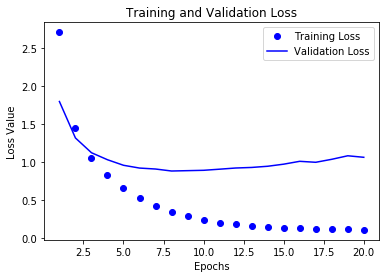

In [39]:
# Plotting losses
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label="Training Loss")
plt.plot(epochs, val_loss_values, 'b', label="Validation Loss")

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()

plt.show()

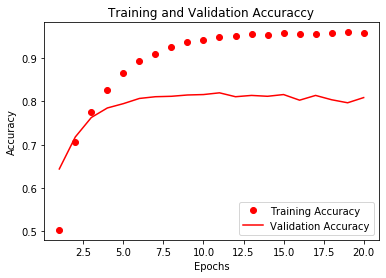

In [41]:
# Training and Validation Accuracy

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, acc_values, 'ro', label="Training Accuracy")
plt.plot(epochs, val_acc_values, 'r', label="Validation Accuracy")

plt.title('Training and Validation Accuraccy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

We observe that _minimum validation loss_ and _maximum validation Accuracy_ is achived at around 9-10 epochs. After that we observe 2 trends:
* increase in validation loss and decrese in training loss
* decrease in validation accuracy and increase in training accuracy

This implies that the model is getting better at classifying the sentiment of the training data, but making consistently worse predictions when it encounters new, previously unseed data. This is the hallmark of _Overfitting_. After the 10th epoch the model begins to fit too closely to the trainning data.

To address overfitting, we will reduce the number of epochs to 9. These results may vary depending on your machine and due to the very nature of the random assignment of weights that may vary from model to mode.

In our case we will stop training after 9 epochs.

## Retraining the model from scratch

In [42]:
# Model definition
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

# Model Compilation
model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

# Training the model
model.fit(partial_X_train,
         partial_Y_train,
         epochs=9,
         batch_size=512,
         validation_data=(X_val, Y_val))

Epoch 1/9
16/16 [==============================] - 1s 50ms/step - loss: 2.6952 - accuracy: 0.5292 - val_loss: 1.7771 - val_accuracy: 0.6350
Epoch 2/9
16/16 [==============================] - 1s 41ms/step - loss: 1.4178 - accuracy: 0.7066 - val_loss: 1.2936 - val_accuracy: 0.7260
Epoch 3/9
16/16 [==============================] - 1s 59ms/step - loss: 1.0297 - accuracy: 0.7835 - val_loss: 1.1201 - val_accuracy: 0.7560
Epoch 4/9
16/16 [==============================] - 1s 41ms/step - loss: 0.8048 - accuracy: 0.8324 - val_loss: 1.0212 - val_accuracy: 0.7840
Epoch 5/9
16/16 [==============================] - 1s 37ms/step - loss: 0.6392 - accuracy: 0.8680 - val_loss: 0.9626 - val_accuracy: 0.8040
Epoch 6/9
16/16 [==============================] - 1s 40ms/step - loss: 0.5173 - accuracy: 0.8945 - val_loss: 0.9302 - val_accuracy: 0.8110
Epoch 7/9
16/16 [==============================] - 1s 51ms/step - loss: 0.4156 - accuracy: 0.9142 - val_loss: 0.9278 - val_accuracy: 0.8090
Epoch 8/9
16/16 [===

## Predicting results and evaluation

In [44]:
results = model.evaluate(X_test, Y_test)

71/71 [==============================] - 2s 31ms/step - loss: 0.9838 - accuracy: 0.7943


In [45]:
results

[0.9837799668312073, 0.7943009734153748]

Our approaches reaches an efficieny of ~80%